In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import SVD
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import CoClustering
from surprise import BaselineOnly
from surprise import AlgoBase
from surprise import PredictionImpossible
import math
import heapq
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [13]:
def get_models():
    
    models = dict()
    models['SVD'] = SVD()
    models['User_KNN'] = KNNWithMeans(sim_options={'name':'cosine', 'user_based':True})
    models['Item_KNN'] = KNNBaseline(sim_options={'name':'msd', 'user_based':False})
    models['CoClustering'] = CoClustering()
    models['BaselineOnly'] = BaselineOnly()
    
    return models

In [14]:
def evaluate(estimators):
    
    evaluation = {}

    for name, estimator in estimators.items():
        print('training '+name+'...')
        estimator.fit(trainset)
        print('evaluating '+name+'...')
        predictions = estimator.test(valset)
        mae = accuracy.mae(predictions, verbose=False)
        rmse =  accuracy.rmse(predictions, verbose=False)
        evaluation[name]=[mae, rmse]
        print('done evaluating', name, '...')
        print('----------------------------------------')

    print("{:<20} {:<20} {:<20}".format("Algorithm", "MAE", "RMSE"))
    for name, metrics in evaluation.items():
        print("{:<20} {:<20.4f} {:<20.4f}".format(name, metrics[0], metrics[1]))

    print('----------------------------------------')

    return evaluation

In [15]:
def kfold_evalution(estimators, cv=10):

    skf=StratifiedKFold(n_splits=cv)
    evaluation={name:[] for name in estimators}

    for name, estimator in estimators.items():
        print('evaluating '+name+'...')

        for train_index, test_index in skf.split(clean_train['Label'], clean_train['BeerID']):

            train_split = clean_train.loc[train_index, :]
            test_split = clean_train.loc[test_index, :]
            data_train = Dataset.load_from_df(train_split[['ReviewerID', 'BeerID', 'Label']], reader)
            data_test = Dataset.load_from_df(test_split[['ReviewerID', 'BeerID', 'Label']], reader)
            trainset = data_train.build_full_trainset()
            NA, testset = train_test_split(data_test, test_size=1.0)

            estimator.fit(trainset)
            predictions = estimator.test(testset)
            mae = accuracy.mae(predictions, verbose=False)
            evaluation[name].append(mae)
        
        print('done evaluating '+name+'...')
        print('----------------------------------------')

    
    results = evaluation.values()
    names = evaluation.keys()
    fig = plt.figure(figsize=(15,5))
    plt.boxplot(results, labels=names, showmeans=True)
    plt.show(block=False)


In [16]:
def get_content_dict():

    print('loading the dataframe with selected features (BrewerID and ABV)...')

    with open('A3data/features.tsv', 'r') as f:
        lines = f.read().splitlines()
        lines_list = [line.split('\t') for line in lines]
        rowid = [int(line[0]) for line in lines_list]
        brewerid = [int(line[1]) for line in lines_list]
        abv = [line[2] for line in lines_list]
        feature_dict = {'RowID':rowid, 'BrewerID':brewerid, 'ABV':abv}
        feature_df = pd.DataFrame(feature_dict)
        feature_df['ABV'].replace({'':0}, inplace=True)
        feature_df = feature_df.astype({'ABV':float})
    print('---------------------------------------')
    print('generating a content dictionary, BeerID being the keys, [BrewerID, ABV] being the values...')
      
    train_df = pd.read_csv('A3data/train.tsv', sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType', 'Label'])
    content_df = train_df.merge(feature_df, on='RowID', how='left').loc[:,['BeerID', 'BrewerID', 'ABV']]
    content_df.drop_duplicates(inplace=True)
    content_df = content_df.reset_index(drop=True)

    content_dict = {beerid:content_df[content_df['BeerID']==beerid].loc[:,['BrewerID', 'ABV']].values for beerid in content_df.BeerID.values}

    print('done generating the dictionary...')
    print('---------------------------------------')

    return content_dict

In [17]:
class Content_KNN(AlgoBase):

    def __init__(self, k=40, sim_options={}):
        AlgoBase.__init__(self)
        self.k = k

    def fit(self, trainset, content_dict):
        AlgoBase.fit(self, trainset)

        print('computing content-based similarity matrix...')

        self.similarities = np.zeros((self.trainset.n_items, self.trainset.n_items))

        for thisRating in range(self.trainset.n_items):
            if (thisRating % 1000 == 0):
                print(thisRating, 'of', self.trainset.n_items)
            for otherRating in range(thisRating+1, self.trainset.n_items):
                thisBeerID = int(self.trainset.to_raw_iid(thisRating))
                otherBeerID = int(self.trainset.to_raw_iid(otherRating))
                
                thisABV = content_dict[thisBeerID][0][1]
                otherABV = content_dict[otherBeerID][0][1]
                diff = abs(thisABV-otherABV)
                sim_ABV = math.exp(-diff/10.0)

                thisBrewerID = content_dict[thisBeerID][0][0]
                otherBrewerID = content_dict[otherBeerID][0][0]
                if thisBrewerID == otherBrewerID:
                    sim_Brewer = 1
                else:
                    sim_Brewer = 0.01
                
                self.similarities[thisRating, otherRating] = sim_ABV*sim_Brewer
                self.similarities[otherRating, thisRating] = self.similarities[thisRating, otherRating]

        print('done computing similarity matrix...')
        print('---------------------------------------')

        return self

    def predict(self, uid, iid):

        u = trainset.to_inner_uid(uid)
        i = trainset.to_inner_iid(iid)

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unknown...')

        neighbors = []
        for rating in self.trainset.ur[u]:
            sim_tmp = self.similarities[i, rating[0]]
            neighbors.append((sim_tmp, rating[1]))

        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])

        simTotal = weightedSum = 0
        for (simScore, rating) in k_neighbors:
            if (simScore > 0):
                simTotal += simScore
                weightedSum += simScore * rating

        if (simTotal == 0):
            raise PredictionImpossible('No neighbors')

        predictedRating = weightedSum / simTotal

        return predictedRating

In [18]:
def train_level0_estimators(train_path, estimators=get_models()):

    print('training level0 estimators...')

    train_df = pd.read_csv(train_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType', 'Label'])
    reader = Reader(rating_scale=(0,5))
    train_data = Dataset.load_from_df(train_df.loc[:, ['ReviewerID', 'BeerID', 'Label']], reader)
    trainset = train_data.build_full_trainset()
    
    for name, estimator in estimators.items():
        print('training '+name+'...')
        estimator.fit(trainset)
        print('done training '+name+'...')
    
    print('done training level0 estimators')
    print('-----------------------------------------')

    return estimators

In [19]:
def train_level1_estimator(train_path, final_estimator, content_knn, estimators=get_models(), cv=5):

    print('training level1 estimator...')
    print('predicting with level0 estimators...')
    
    train_df = pd.read_csv(train_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType', 'Label'])
    reader = Reader(rating_scale=(0,5))
    skf = StratifiedKFold(n_splits=cv)
    level0_tmp = []

    #stratified kfold
    for train_index, test_index in skf.split(train_df['Label'], train_df['BeerID']):

        train_split_df = train_df.iloc[train_index, :]
        test_split_df = train_df.iloc[test_index, :]
        train_data = Dataset.load_from_df(train_split_df.loc[:, ['ReviewerID', 'BeerID', 'Label']], reader)
        trainset = train_data.build_full_trainset()
        
        for name, estimator in estimators.items():
            estimator.fit(trainset)
            test_split_df[name] = test_split_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimator.predict(x[0],x[1]).est, axis=1)
        
        level0_tmp.append(test_split_df)

    level0_df = pd.concat(level0_tmp)
    level0_df['Content_KNN'] = level0_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: content_knn.predict(x[0],x[1]), axis=1)
    
    print('training level1 estimator with predictions from level0 estimators')

    X_train = level0_df[[name for name in estimators.keys()]+['Content_KNN']]
    y_train = level0_df['Label']
    final_estimator.fit(X_train, y_train)

    print('done training level1 estimator...')
    print('----------------------------------------')

    return final_estimator

In [20]:
def evaluate_stacked_estimator(val_path, estimators, content_knn, final_estimator):

    print('evaluating the stacked model...')

    val_df = pd.read_csv(val_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType', 'Label'])

    for name, estimator in estimators.items():
        val_df[name] = val_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimator.predict(x[0],x[1]).est, axis=1)
    
    # add the prediction from Content_KNN
    val_df['Content_KNN'] = val_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: content_knn.predict(x[0],x[1]), axis=1)

    X_val = val_df[[name for name in estimators.keys()]+['Content_KNN']]
    y_val = val_df['Label']
    y_pred = final_estimator.predict(X_val)

    print('done evaluating the stacked model...')
    print('----------------------------------------')
    
    return mean_absolute_error(y_val, y_pred), mean_squared_error(y_val, y_pred, squared=False)

In [21]:
def stacking_estimator_pred(test_path, estimators, content_knn, final_estimator):
    
    test_df = pd.read_csv(test_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType'])

    
    for name, estimator in estimators.items():
        test_df[name] = test_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimator.predict(x[0],x[1]).est, axis=1)

    test_df['Content_KNN'] = test_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: content_knn.predict(x[0],x[1]), axis=1)


    X_test = test_df[[name for name in estimators.keys()]+['Content_KNN']]
    y_pred = final_estimator.predict(X_test)

    
    return y_pred

training SVD...
evaluating SVD...
done evaluating SVD ...
----------------------------------------
training User_KNN...
Computing the cosine similarity matrix...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
evaluating User_KNN...
done evaluating User_KNN ...
----------------------------------------
training Item_KNN...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
evaluating Item_KNN...
done evaluating Item_KNN ...
----------------------------------------
training CoClustering...


/var/folders/x7/svlnhrr926ldm39vsdrjjk5r0000gn/T/ipykernel_1891/2181159692.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  estimator.fit(trainset)


evaluating CoClustering...
done evaluating CoClustering ...
----------------------------------------
training BaselineOnly...
Estimating biases using als...
evaluating BaselineOnly...
done evaluating BaselineOnly ...
----------------------------------------
Algorithm            MAE                  RMSE                
SVD                  0.4443               0.5924              
User_KNN             0.4591               0.6073              
Item_KNN             0.4418               0.5904              
CoClustering         0.5084               0.6497              
BaselineOnly         0.4417               0.5899              
evaluating SVD...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


done evaluating SVD...
----------------------------------------
evaluating User_KNN...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Computing the cosine similarity matrix...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
done evaluating User_KNN...
----------------------------------------
evaluating Item_KNN...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matr

/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(
/var/folders/x7/svlnhrr926ldm39vsdrjjk5r0000gn/T/ipykernel_1891/1948218898.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  estimator.fit(trainset)


done evaluating CoClustering...
----------------------------------------
evaluating BaselineOnly...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
done evaluating BaselineOnly...
----------------------------------------


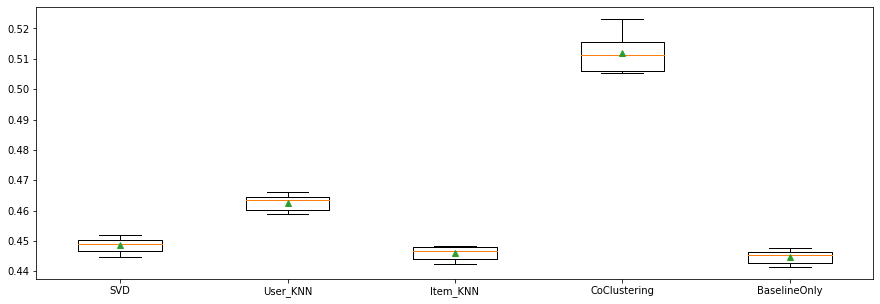

loading the dataframe with selected features (BrewerID and ABV)...
---------------------------------------
generating a content dictionary, BeerID being the keys, [BrewerID, ABV] being the values...
done generating the dictionary...
---------------------------------------
computing content-based similarity matrix...
0 of 14228
1000 of 14228
2000 of 14228
3000 of 14228
4000 of 14228
5000 of 14228
6000 of 14228
7000 of 14228
8000 of 14228
9000 of 14228
10000 of 14228
11000 of 14228
12000 of 14228
13000 of 14228
14000 of 14228
done computing similarity matrix...
---------------------------------------
Algorithm            MAE                  RMSE                
SVD                  0.4443               0.5924              
User_KNN             0.4591               0.6073              
Item_KNN             0.4418               0.5904              
CoClustering         0.5084               0.6497              
BaselineOnly         0.4417               0.5899              
Content_KNN     

/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
done training User_KNN...
training Item_KNN...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
done training Item_KNN...
training CoClustering...


/var/folders/x7/svlnhrr926ldm39vsdrjjk5r0000gn/T/ipykernel_1891/2801158563.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  estimator.fit(trainset)


done training CoClustering...
training BaselineOnly...
Estimating biases using als...
done training BaselineOnly...
done training level0 estimators
-----------------------------------------
training level1 estimator...
predicting with level0 estimators...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/x7/svlnhrr926ldm39vsdrjjk5r0000gn/T/ipykernel_1891/4293881125.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_split_df[name] = test_split_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimator.predict(x[0],x[1]).est, axis=1)


Computing the cosine similarity matrix...


/Users/zhenqian/opt/anaconda3/envs/PDSA3/lib/python3.8/site-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/x7/svlnhrr926ldm39vsdrjjk5r0000gn/T/ipykernel_1891/4293881125.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  estimator.fit(trainset)


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
training level1 estimator with predictions from level0 estimators
done training level1 estimator...
-------------------------

In [22]:
if __name__ == "__main__":

    train_headers=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType', 'Label']
    df_train = pd.read_csv('A3data/train.tsv', sep='\t', names=train_headers)
    clean_train = df_train.drop(['RowID','BeerName','BeerType'], axis=1)
    df_val = pd.read_csv('A3data/val.tsv', sep='\t', names=train_headers)
    clean_val = df_val.drop(['RowID','BeerName','BeerType'], axis=1)
    reader = Reader(rating_scale=(0,5))
    data_train = Dataset.load_from_df(clean_train[['ReviewerID', 'BeerID', 'Label']], reader)
    data_val = Dataset.load_from_df(clean_val[['ReviewerID', 'BeerID', 'Label']], reader)
    trainset = data_train.build_full_trainset()
    NA, valset = train_test_split(data_val, test_size=1.0)

    # section 1: evaluate the built-in models from Surprise
    estimators = get_models()
    evaluation = evaluate(estimators)

    # section 2: kfold cross validation for Suprise built-in models and visualization
    estimators = get_models()
    kfold_evalution(estimators)

    # section 3: build a content based KNN model and evaluate it
    content_dict = get_content_dict()
    cknn = Content_KNN()
    cknn.fit(trainset, content_dict)
    pred = df_val.loc[:,['ReviewerID', 'BeerID']].apply(lambda x: cknn.predict(x[0], x[1]), axis=1).values
    mae = mean_absolute_error(df_val['Label'], pred)
    rmse = mean_squared_error(df_val['Label'], pred, squared=False)
    evaluation['Content_KNN']=[mae, rmse]

    print("{:<20} {:<20} {:<20}".format("Algorithm", "MAE", "RMSE"))
    for name, metrics in evaluation.items():
        print("{:<20} {:<20.4f} {:<20.4f}".format(name, metrics[0], metrics[1]))

    print('----------------------------------------')


    # section 4: build a ensemble model to wrap up all models evaluated above
    train_path = 'A3data/train.tsv'
    val_path = 'A3data/val.tsv'
    final_estimator = LinearRegression()

    estimators = train_level0_estimators(train_path, estimators=get_models())
    final_estimator = train_level1_estimator (train_path, final_estimator, cknn, estimators=get_models())
    mae, rmse = evaluate_stacked_estimator(val_path, estimators, cknn, final_estimator)

    evaluation['Ensemble Model']=[mae, rmse]

    print("{:<20} {:<20} {:<20}".format("Algorithm", "MAE", "RMSE"))
    for name, metrics in evaluation.items():
        print("{:<20} {:<20.4f} {:<20.4f}".format(name, metrics[0], metrics[1]))

    print('----------------------------------------')

    # create predictions on test set using BaselineOnly: run-1
    print('saving a total of 3 test runs...')
    print('saving run-1 (1/3)...')
    test_path='A3data/test.tsv'
    test_df=pd.read_csv(test_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType'])
    y_pred = test_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimators['BaselineOnly'].predict(x[0],x[1]).est, axis=1)
    test_df['pred']=y_pred

    test_df[['RowID', 'pred']].to_csv('A3-1.tsv', sep='\t', index=False, header=False)

    # create predictions on test set using Item_KNN: run-2
    print('saving run-2 (2/3)...')
    test_path='A3data/test.tsv'
    test_df=pd.read_csv(test_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType'])
    y_pred = test_df.loc[:, ['ReviewerID', 'BeerID']].apply(lambda x: estimators['Item_KNN'].predict(x[0],x[1]).est, axis=1)
    test_df['pred']=y_pred

    test_df[['RowID', 'pred']].to_csv('A3-2.tsv', sep='\t', index=False, header=False)

    # create predictions on test set using ensemble model: run-3
    print('saving run-3 (3/3)...')
    test_path='A3data/test.tsv'
    test_df=pd.read_csv(test_path, sep='\t', names=['RowID', 'BeerID', 'ReviewerID', 'BeerName', 'BeerType'])
    y_pred = stacking_estimator_pred(test_path, estimators, cknn, final_estimator)
    test_df['pred']=y_pred

    test_df[['RowID', 'pred']].to_csv('A3-3.tsv', sep='\t', index=False, header=False)

    print('all tasks completed...thank you...')

    # show the figure correspond to section 2
    plt.show()

   

    

    

    